### Obtenición de ángulos en flechas sobre el pavimento

Utilizar una red YOLO-OBB no nos sirve porque no obtendríamos la orientación, sino el rectángulo rotado que mejor encaja con el objeto.

La propuesta para obtener la orientación de las flechas consiste en diseñar una CNN ad-hoc que entrenaremos con las imágenes de las flechas extraidas por YOLO y la rotación proporcionada en los labels.

Para ello se eliminarán todas las imágenes que no tienen flechas, y de las que sí tienen se recortará cada flecha (puede haber varias y se reescalará a unas dimensiones fijas (por determinar), añadiendo el ángulo reportado en los labels.

Con ese dataset se entrenará una red tipo VGG para obtener dada una imagen de una flecha el ángulo que forma.

In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
display('Álvaro Felipe Perez')
display('Miguel Gómez Prieto')

'Álvaro Felipe Perez'

'Miguel Gómez Prieto'

In [2]:
import os
import pandas as pd
import numpy as np
import cv2

import matplotlib.pyplot as plt

def load_samples (directory, size=None):
    data = pd.read_csv(directory, sep='\t', header=None) 

    #data = data[:10]
    print(data)
    
    X = []
    Y = []
    for i in range(len(data)):
        print('.', end='')
        # carga la imagen
        imgname = data.iloc[i,0]
        img = cv2.imread(imgname)
        if size != None:
            img = cv2.resize(img, size)
        X.append(img)
        Y.append(data.iloc[i,1])

    return (np.array(X), np.array(Y))

In [3]:
X, Y = load_samples("dataset_cleaned.csv",(64,64)) # for model that require higher than 64x64 resolution
# Convertir a float y escalar a [0,1]

# Calcular la media y el std por canal (suponiendo imágenes RGB)
mean = X.mean(axis=(0, 1, 2))  # Calcula la media para cada canal
std = X.std(axis=(0, 1, 2))      # Calcula el std para cada canal

# Normalizar cada imagen
X = (X - mean) / std

                                                   0         1
0        dataset/lyrs=y&x=498928&y=388383&z=20-0.png  0.747256
1        dataset/lyrs=y&x=498933&y=388386&z=20-1.png  0.085187
2        dataset/lyrs=y&x=498934&y=388391&z=20-2.png  0.634782
3        dataset/lyrs=y&x=498934&y=388391&z=20-3.png  0.140102
4        dataset/lyrs=y&x=498940&y=388395&z=20-4.png  0.887765
...                                              ...       ...
6696  dataset/lyrs=y&x=530663&y=391686&z=20-7116.png  0.514914
6697  dataset/lyrs=y&x=530669&y=391622&z=20-7117.png  0.385349
6698  dataset/lyrs=y&x=530672&y=391647&z=20-7118.png  0.652626
6699  dataset/lyrs=y&x=530676&y=391636&z=20-7119.png  0.598877
6700  dataset/lyrs=y&x=530680&y=391631&z=20-7120.png  0.615035

[6701 rows x 2 columns]
...........................................................................................................................................................................................................................

Normalizamos las imagenes

In [4]:
print(X.shape)
print(Y.shape)

# get train and test sets
import sklearn.model_selection

X_train, X_test, Y_train, Y_test = sklearn.model_selection.train_test_split(X, Y, test_size=0.10) # this random_state is similar to the bootstrap results

(6701, 64, 64, 3)
(6701,)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.813738758273247..2.7050738822529556].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.865748362940837..3.0751640804802096].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1778059909463767..2.789111254808465].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.6458924329546862..2.7050738822529556].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.4496715256001171..2.6318965945619848].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0217771769436066..2.789111254808465].
Clipping input data to the

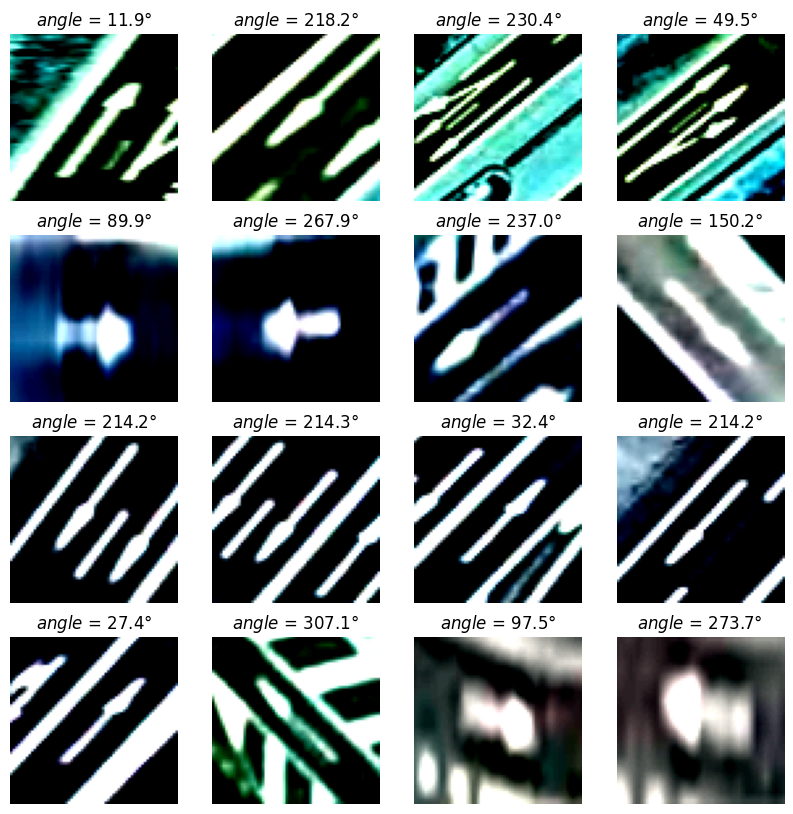

In [5]:
# imprime algunos ejemplos

N = 16

fig, axs = plt.subplots(N//4,4,figsize=(10, 10*N//16))
axs = axs.flatten()
plt.axis('off')

im0 = 567
for i in range(N):
    axs[i].axis('off')
    axs[i].imshow(X[im0+i])
    #axs[i].title.set_text(f"$angle$ = {(Y[im0+i]):.3f}")
    axs[i].title.set_text(f"$angle$ = {(360*Y[im0+i]):.1f}°")

#plt.savefig("test.png", bbox_inches='tight')

In [6]:
print('Número de nulos:',pd.read_csv("dataset_cleaned.csv", sep='\t', header=None).isna().sum().sum())

Número de nulos: 0


Al no haber nulos, se puede entrenar con todas las imagenes

In [7]:
import torch

def set_device ():
    if torch.backends.mps.is_available(): # para usar con mac silicon
        device = "mps"
    elif torch.cuda.is_available():
        device = "cuda"
    else:
        device = "cpu"
    torch.set_default_device(device)
    print(f"Using {torch.device(device)} device")
    return torch.device(device)

# set_device()
torch.set_default_device('cpu')

In [8]:
from torch import nn

class CNNArrowClassifier(nn.Module):
    def __init__(self):
        super(CNNArrowClassifier, self).__init__()
        self.conv_layers = nn.Sequential()
        
        in_channels = 8  # Potencias de 2

        # Primera capa con 8 canales
        self.conv_layers.add_module("conv_initial", nn.Conv2d(3, in_channels, kernel_size=3, stride=1, padding=1))
        self.conv_layers.add_module("relu_initial", nn.ReLU())
        self.conv_layers.add_module("pool_initial", nn.MaxPool2d(kernel_size=2, stride=2))
        
        num_cycles = 2  # Ajustado a 3 para obtener 64 canales en la última capa
        for i in range(num_cycles):
            out_channels = 4 * in_channels  # 32, 128
            self.conv_layers.add_module(f"conv1_{i}", nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1))
            self.conv_layers.add_module(f"relu1_{i}", nn.ReLU())
            self.conv_layers.add_module(f"conv2_{i}", nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1))
            self.conv_layers.add_module(f"relu2_{i}", nn.ReLU())
            self.conv_layers.add_module(f"pool_{i}", nn.MaxPool2d(kernel_size=2, stride=2))
            in_channels = out_channels

        # Ajuste de dimensiones para la capa totalmente conectada
        self.fc_layers = nn.Sequential(
            nn.LazyLinear(512),
            nn.LeakyReLU(negative_slope=0.02),
            nn.Dropout(0.8),
            nn.Linear(512, 1),
            # nn.LeakyReLU(),
            # nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.reshape(x.size(0), -1)  # Flatten the tensor
        x = self.fc_layers(x)
        # x = 0.5 * (torch.tanh(x) + 1) # Aseguramos entre 1 y 0
        return x

# Ejemplo de uso
if __name__ == "__main__":
    model = CNNArrowClassifier()
    print(model)

CNNArrowClassifier(
  (conv_layers): Sequential(
    (conv_initial): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu_initial): ReLU()
    (pool_initial): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv1_0): Conv2d(8, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu1_0): ReLU()
    (conv2_0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu2_0): ReLU()
    (pool_0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv1_1): Conv2d(32, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu1_1): ReLU()
    (conv2_1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu2_1): ReLU()
    (pool_1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_layers): Sequential(
    (0): LazyLinear(in_features=0, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.02)
    (2): Dropout(p

In [ ]:
# Inicializar el modelo, la pérdida y el optimizador

# Función de pérdida para ángulos
def angular_loss(output, target): # MAE teniendo en cuenta que 1 y 0 son lo mismo
    diff = torch.abs(output - target)
    return torch.mean(torch.min(diff, 1 - diff) ** 2)  # MSE


model = CNNArrowClassifier()
criterion = angular_loss

# Convertir las imágenes y etiquetas a tensores
X_tensor = torch.tensor(X_train, dtype=torch.float32)
Y_tensor = torch.tensor(Y_train, dtype=torch.float32)

# Cambiar la forma de las imágenes para que sea compatible con la entrada de la red
X_tensor = X_tensor.permute(0, 3, 1, 2)  # Cambiar de (N, H, W, C) a (N, C, H, W)
X_tensor, X_validate_permanente, Y_tensor, Y_validate_permanente = sklearn.model_selection.train_test_split(X_tensor, Y_tensor, test_size=0.15, random_state=42) # sacamos indices con validacion


In [21]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
# Entrenamiento de la red
num_epochs = 81
batch_size = 16
for epoch in range(num_epochs):
    permutation = torch.randperm(X_tensor.size(0))  # Mezclar los datos en cada epoch
    permutation_train, permutation_validacion = sklearn.model_selection.train_test_split(permutation, test_size=0.2, random_state=42) # sacamos indices con validacion
    for i in range(0, permutation_train.size(0), batch_size):
        indices = permutation_train[i:i + batch_size]
        batch_x, batch_y = X_tensor[indices], Y_tensor[indices]
        
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y.view(-1, 1))
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    if epoch%5 == 0: # Todas
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")        
        # Fase de validación
        model.eval()
        with torch.no_grad():
            valid_loss = 0.0
            for i in range(0, len(permutation_validacion), batch_size):
                indices = permutation_validacion[i:i + batch_size]
                batch_x, batch_y = X_tensor[indices], Y_tensor[indices]
                
                outputs = model(batch_x)
                loss = criterion(outputs, batch_y.view(-1, 1))
                valid_loss += loss.item()
            
            valid_loss /= len(permutation_validacion) // batch_size
            print(f"Temporal validation Loss: {valid_loss:.4f}")
        with torch.no_grad():  # Desactivar el cálculo de gradiente para la prueba
            outputs = model(X_validate_permanente)  # Evaluar todo el conjunto de prueba a la vez
            loss = criterion(outputs, Y_validate_permanente.view(-1, 1))  # Calcular la pérdida en todos los datos
            valid_loss = loss.item()
        print(f"Real validation Loss: {valid_loss:.4f}")
        print()
        model.train()

print("Entrenamiento completado.")

Epoch [1/16], Loss: 0.0012
Temporal validation Loss: 0.0005
Real validation Loss: 0.0126

Epoch [6/16], Loss: 0.0006
Temporal validation Loss: 0.0006
Real validation Loss: 0.0127

Epoch [11/16], Loss: 0.0001
Temporal validation Loss: 0.0004
Real validation Loss: 0.0127

Epoch [16/16], Loss: 0.0031
Temporal validation Loss: 0.0006
Real validation Loss: 0.0124

Entrenamiento completado.


In [22]:
def test_model(model, X_test_tensor, Y_test_tensor):
    model.eval()  # Establecer el modelo en modo evaluación

    criterion = angular_loss

    with torch.no_grad():  # Desactivar el cálculo de gradiente para la prueba
        outputs = model(X_test_tensor)  # Evaluar todo el conjunto de prueba a la vez
        loss = criterion(outputs, Y_test_tensor.view(-1, 1))  # Calcular la pérdida en todos los datos
        test_loss = loss.item()

        predicted = (outputs * 360) % 360  # Convertir a grados

    print(f'Test Loss: {test_loss:.4f}')


In [23]:
# Convertir las imágenes y etiquetas a tensores
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
X_test_tensor = X_test_tensor.permute(0, 3, 1, 2)  # Cambiar de (N, H, W, C) a (N, C, H, W)

Y_test_tensor = torch.tensor(Y_test, dtype=torch.float32)

test_model(model, X_test_tensor, Y_test_tensor)

Test Loss: 0.0123


In [25]:
import pickle
with open('modelo123.pkl','wb') as f:
    pickle.dump(model, f)

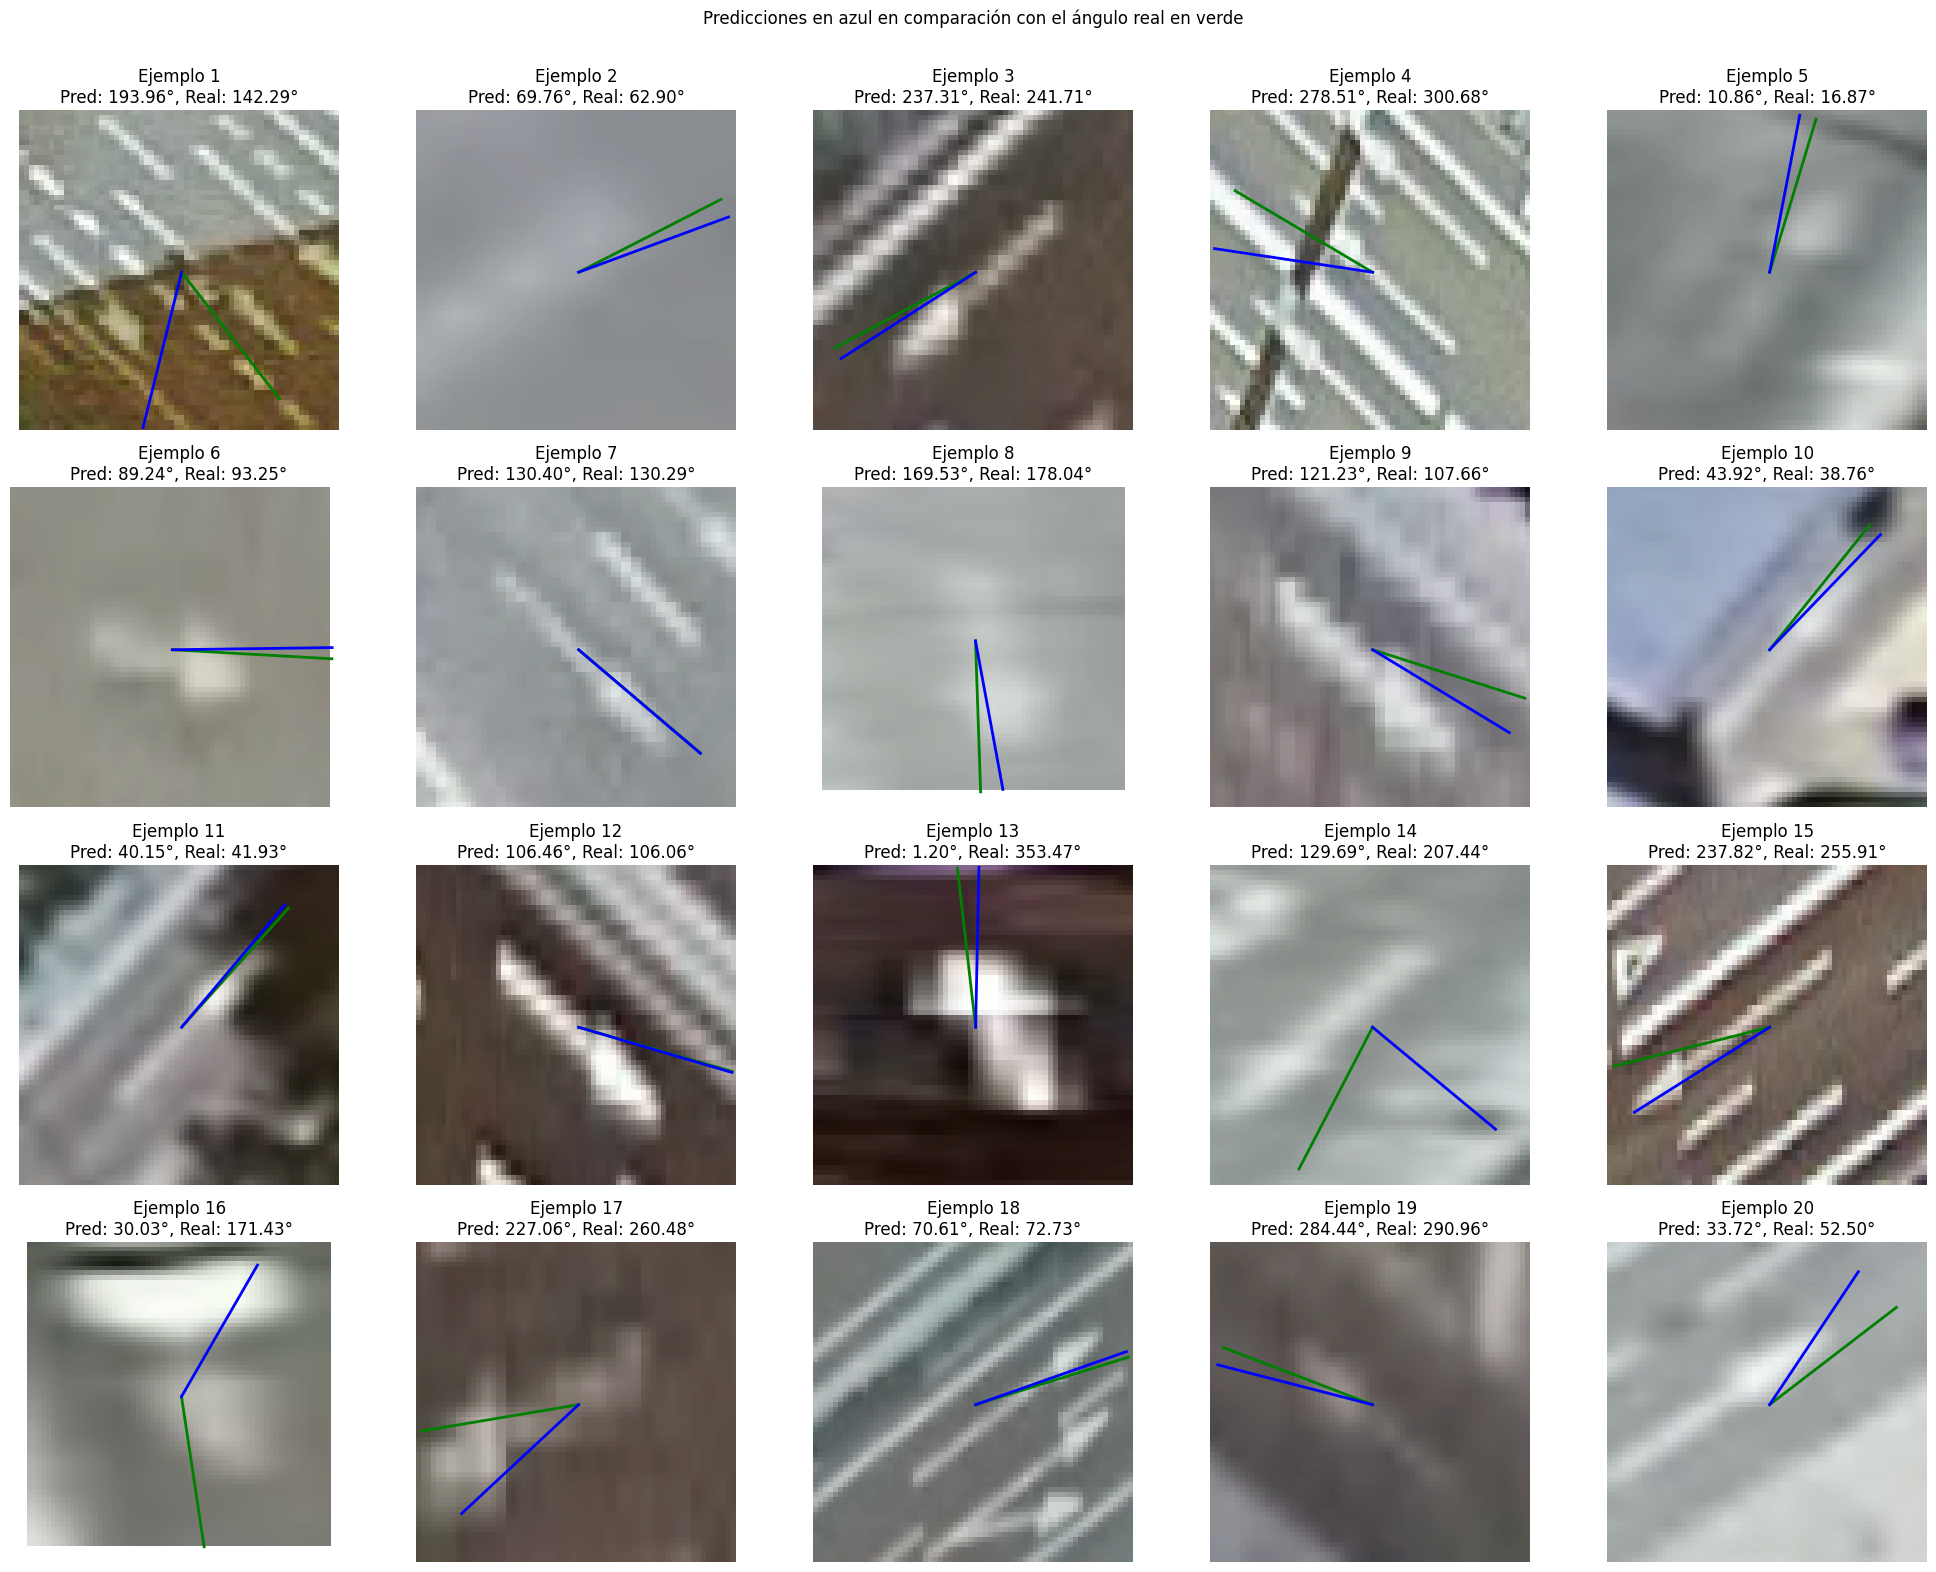

Test Loss: 0.0600


In [26]:
import math

def test_model_with_visualization(model, X_test_tensor, Y_test_tensor, std, mean, num_examples=10, desplazamiento=10):
    model.eval()  # Modo evaluación
    criterion = nn.MSELoss()
    
    # Seleccionar los ejemplos a visualizar
    X_examples = X_test_tensor[desplazamiento:num_examples + desplazamiento]
    Y_examples = Y_test_tensor[desplazamiento:num_examples + desplazamiento]
    mean_examples = mean[desplazamiento:num_examples + desplazamiento]
    std_examples = std[desplazamiento:num_examples + desplazamiento]
    with torch.no_grad():
        outputs = model(X_examples)
        loss = criterion(outputs, Y_examples.view(-1, 1))
    
    # Calcular número de filas y columnas para los subplots
    ncols = math.ceil(math.sqrt(num_examples))
    nrows = math.ceil(num_examples / ncols)
    
    fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*4, nrows*4))
    # Si axes es una matriz 2D, la aplastamos para iterar de forma lineal
    axes = axes.flatten() if num_examples > 1 else [axes]
    
    for i in range(num_examples):
        # Convertir la imagen a formato (H, W, C) para plt.imshow()
        img = X_examples[i].cpu().permute(1, 2, 0).numpy()
        img_denorm = img * std_examples + mean_examples
        img_denorm = np.clip(img_denorm, 0, 255)  # Opcional, para asegurar que estén en [0,255]
        img_uint8 = img_denorm.astype(np.uint8)
        axes[i].imshow(img_uint8)

        
        # Obtener ángulos en grados (se supone que Y está normalizado a [0,1], y se multiplica por 360)
        pred_angle = 360 * outputs[i].item()
        actual_angle = 360 * Y_examples[i].item()
        
        # Definir centro y longitud de línea (tomamos 1/3 del mínimo entre ancho y alto)
        h, w, _ = img.shape
        center = (w/2, h/2)
        line_length = min(h, w) *0.5
        
        # Convertir ángulos a radianes y calcular extremos de las líneas.
        # Se resta la componente sin para invertir el eje y (ya que en imshow el eje y crece hacia abajo).
        pred_rad = np.deg2rad(-pred_angle + 90)
        actual_rad = np.deg2rad(-actual_angle + 90)

        
        # Para el ángulo predicho (línea azul)
        x_end_pred = center[0] + line_length * np.cos(pred_rad)
        y_end_pred = center[1] - line_length * np.sin(pred_rad)
        
        # Para el ángulo real (línea verde)
        x_end_actual = center[0] + line_length * np.cos(actual_rad)
        y_end_actual = center[1] - line_length * np.sin(actual_rad)
        
        # Dibujar líneas en la imagen
        axes[i].plot([center[0], x_end_actual], [center[1], y_end_actual], color='green', linewidth=2, label='Real')
        axes[i].plot([center[0], x_end_pred], [center[1], y_end_pred], color='blue', linewidth=2, label='Predicha')
        
        # Título con los valores de ángulos
        axes[i].set_title(f"Ejemplo {i+1}\nPred: {pred_angle:.2f}°, Real: {actual_angle:.2f}°")
        axes[i].axis('off')
    
    # Si hay subplots vacíos, ocultarlos
    for j in range(i+1, len(axes)):
        axes[j].axis('off')
    
    plt.suptitle('Predicciones en azul en comparación con el ángulo real en verde\n\n')
    plt.tight_layout()
    plt.show()
    
    print(f'Test Loss: {loss.item():.4f}')

# Llamada de ejemplo (asegúrate de que X_test_tensor y Y_test_tensor estén definidos y en el formato adecuado)
test_model_with_visualization(model, X_test_tensor, Y_test_tensor, std, mean, num_examples=20, desplazamiento=0)

